In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/burger-king-churn/train_dataset_hackaton2023_train.gzip
/kaggle/input/burger-king-churn/hackaton2023_test.gzip


In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import shap
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing & feature generation

In [3]:
data = pd.read_parquet('/kaggle/input/burger-king-churn/train_dataset_hackaton2023_train.gzip')
display(data.sample(5))

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
23437735,40543457,28.0,1,train,119.98,2023-06-01 19:46:37,Чай зеленый мал,97.7,Фудкорт с туалетом
1944476,2257343,42.0,1,train,43.97,2022-11-21 19:07:34,"Липтон Грин Дж 0,3",113.8,Фудкорт без туалета
2132303,2916110,NaN,0,train,65.00,2022-12-08 17:19:14,Кинг Фри мал,165.3,Фудкорт без туалета
3361521,6366917,NaN,0,train,69.99,2023-06-10 13:19:06,А4 БУРГЕР 2.0,300.0,Отдельно стоящий с внешней зоной
7247182,11720726,51.0,1,train,69.03,2022-11-12 12:43:24,Up Пирожок с вишней,301.4,Отдельно стоящий


In [4]:
has_toilet_statuses = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий",
    "Фудкорт с туалетом",
    "Отдельно стоящий с внешн.зоной без туалета",
]

hasnt_toilet_statuses = [
    "Фудкорт без туалета",
    "Отдельно стоящий без внешней зоны без туалета",
    "Отдельно стоящий без туалета",
]

with_external_zone = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий с внешн.зоной без туалета",
]

without_external_zone = [
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий без внешней зоны без туалета",
]

is_foodcourt = [
    "Фудкорт с туалетом",
    "Фудкорт без туалета",
]

In [5]:
def preprocess(data, is_train=True):
    
    if is_train:
        data = data[data.format_name != 'Не заполнено']
        #slight date_diff_post aligning
        data.date_diff_post.fillna(-1, inplace=True)
        data.date_diff_post = data.date_diff_post.astype(int)
    
    # make has_toilet column and store there true or false based on has_toilet_statuses
    data['has_toilet'] = data.format_name.isin(has_toilet_statuses)

    # if has external zone then store 2, else 1, if not in with/without_external_zone then store 0
    data['has_external_zone'] = data.format_name.apply(
        lambda x: 2 if x in with_external_zone else 1 if x in without_external_zone else 0
    )

    # 2 - has external zone
    # 1 - hasnt external zone
    # 0 - not defined

    data['is_foodcourt'] = data.format_name.isin(is_foodcourt)

    data.drop('format_name', axis=1, inplace=True)
    
    if is_train:
        # filter outliers in dish_name that have less than 10000 rows
        dish_name_counts = data.dish_name.value_counts()
        dish_name_counts = dish_name_counts[dish_name_counts > 50000]
        data = data[data.dish_name.isin(dish_name_counts.index)]
    
    # create bill_id based on startdatetime and customer_id
    data['bill_id'] = data.groupby(['startdatetime', 'customer_id']).ngroup()
    
    # drop group_name
    data.drop('group_name', axis=1, inplace=True)
    
    # label encode dish_name
    le = LabelEncoder()
    data['dish_name'] = le.fit_transform(data.dish_name)
    
    if is_train:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'date_diff_post': 'first',
            'buy_post': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    else:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    
    #datetime to timestamp
    data['startdatetime'] = [datetime.timestamp(n) for n in data['startdatetime']]
    
    data['dish_amount'] = [len(n) for n in data['dish_name']]
    
    return data

In [6]:
data = preprocess(data)
data.sample(5)

,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,date_diff_post,buy_post,revenue,ownareaall_sqm,dish_amount
1452331,1452331,6022795,"[2, 21, 24, 41]",1.679230e+09,True,1,False,18,1,379.97,591.1,4
308825,308825,24201464,[8],1.666730e+09,False,0,True,18,1,399.96,101.6,1
1937137,1937137,8563488,"[32, 18, 22, 18, 40, 7, 7, 42]",1.684276e+09,True,1,False,24,1,942.10,300.0,8
1107854,1107854,21311298,"[21, 42, 28, 27, 52, 44, 53]",1.675526e+09,False,0,True,7,1,515.98,78.9,7
2296555,2296555,21517695,"[6, 48, 42, 56, 17]",1.687887e+09,True,2,False,2,1,424.01,291.1,5


In [7]:
cat_feat = ['has_external_zone', 'has_toilet', 'is_foodcourt']

# Train test split

In [8]:
x = data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]
y = data[['buy_post', 'date_diff_post']]
y_clf = y['buy_post']
y_reg = y['date_diff_post']

x_train, x_test, y_train, y_test = train_test_split(x, y)
y_train_clf, y_test_clf = y_train['buy_post'], y_test['buy_post']
y_train_reg, y_test_reg = y_train['date_diff_post'], y_test['date_diff_post'] 

In [9]:
train_pool_clf = Pool(x_train, y_train_clf, cat_features=cat_feat)
eval_pool_clf = Pool(x_test, y_test_clf, cat_features=cat_feat)
full_train_clf = Pool(x, y_clf, cat_features=cat_feat)

train_pool_reg = Pool(x_train, y_train_reg, cat_features=cat_feat)
eval_pool_reg = Pool(x_test, y_test_reg, cat_features=cat_feat)
full_train_reg = Pool(x, y_reg, cat_features=cat_feat)

# Model training

In [10]:
cbc = CatBoostClassifier(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(train_pool_clf, eval_set=eval_pool_clf)

0:	learn: 0.5799747	test: 0.5797018	best: 0.5797018 (0)	total: 332ms	remaining: 32.9s
1:	learn: 0.5354298	test: 0.5349784	best: 0.5349784 (1)	total: 567ms	remaining: 27.8s
2:	learn: 0.5160721	test: 0.5155507	best: 0.5155507 (2)	total: 887ms	remaining: 28.7s
3:	learn: 0.5080759	test: 0.5074676	best: 0.5074676 (3)	total: 1.1s	remaining: 26.4s
4:	learn: 0.5045380	test: 0.5038787	best: 0.5038787 (4)	total: 1.42s	remaining: 27.1s
5:	learn: 0.5030023	test: 0.5023164	best: 0.5023164 (5)	total: 1.75s	remaining: 27.5s
6:	learn: 0.5022726	test: 0.5015909	best: 0.5015909 (6)	total: 2.05s	remaining: 27.2s
7:	learn: 0.5019983	test: 0.5012972	best: 0.5012972 (7)	total: 2.26s	remaining: 26s
8:	learn: 0.5017755	test: 0.5010752	best: 0.5010752 (8)	total: 2.56s	remaining: 25.9s
9:	learn: 0.5015858	test: 0.5009044	best: 0.5009044 (9)	total: 2.92s	remaining: 26.3s
10:	learn: 0.5014274	test: 0.5007754	best: 0.5007754 (10)	total: 3.24s	remaining: 26.2s
11:	learn: 0.5012354	test: 0.5006116	best: 0.5006116 (1

In [11]:
cbr = CatBoostRegressor(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(train_pool_reg, eval_set=eval_pool_reg)

0:	learn: 16.0732146	test: 16.0663316	best: 16.0663316 (0)	total: 320ms	remaining: 31.7s
1:	learn: 16.0670070	test: 16.0603601	best: 16.0603601 (1)	total: 631ms	remaining: 30.9s
2:	learn: 16.0624157	test: 16.0558594	best: 16.0558594 (2)	total: 895ms	remaining: 28.9s
3:	learn: 16.0599135	test: 16.0538971	best: 16.0538971 (3)	total: 1.2s	remaining: 28.9s
4:	learn: 16.0580414	test: 16.0521669	best: 16.0521669 (4)	total: 1.47s	remaining: 27.8s
5:	learn: 16.0564238	test: 16.0508243	best: 16.0508243 (5)	total: 1.75s	remaining: 27.4s
6:	learn: 16.0549745	test: 16.0497957	best: 16.0497957 (6)	total: 2.01s	remaining: 26.7s
7:	learn: 16.0538252	test: 16.0485276	best: 16.0485276 (7)	total: 2.28s	remaining: 26.3s
8:	learn: 16.0528267	test: 16.0479010	best: 16.0479010 (8)	total: 2.57s	remaining: 26s
9:	learn: 16.0516233	test: 16.0468523	best: 16.0468523 (9)	total: 2.83s	remaining: 25.5s
10:	learn: 16.0509505	test: 16.0464583	best: 16.0464583 (10)	total: 3.1s	remaining: 25.1s
11:	learn: 16.0504941	t

In [12]:
'''
parameters = {'depth'         : [8, 10],
              'learning_rate' : [0.3, 0.4],
              'iterations'    : [10, 20],
              'l2_leaf_reg'   : [10, 15, 20]}
              
randomized_search_results = cbc.randomized_search(
    parameters,
    train_pool,
    n_iter=9,
    plot=True
)

randomized_search_results
'''

"\nparameters = {'depth'         : [8, 10],\n              'learning_rate' : [0.3, 0.4],\n              'iterations'    : [10, 20],\n              'l2_leaf_reg'   : [10, 15, 20]}\n              \nrandomized_search_results = cbc.randomized_search(\n    parameters,\n    train_pool,\n    n_iter=9,\n    plot=True\n)\n\nrandomized_search_results\n"

In [13]:
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Evaluating model

In [14]:
f1_score(xgbc.predict(x_test), y_test_clf)

0.8861497520042593

In [15]:
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['F1'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Precision'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Recall'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Accuracy'][:3])

[0.8861744027713901, 0.8861744027713901, 0.8861744027713901]
[0.7956132494856868, 0.7956132494856868, 0.7956132494856868]
[1.0, 1.0, 1.0]
[0.7956132494856868, 0.7956132494856868, 0.7956132494856868]


In [16]:
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['MAE'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['Poisson'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['RMSE'][:3])

[13.230153352280096, 13.221372734076507, 13.214120194411718]
[7390044.6613802975, 7997769.375052257, 8570586.42672018]
[16.066331568617393, 16.060360132669356, 16.055859430959963]


In [17]:
cbc.get_feature_importance()

array([37.97739453,  6.402921  ,  3.1239557 ,  2.98027458, 12.27784624,
       27.09128255, 10.1463254 ])

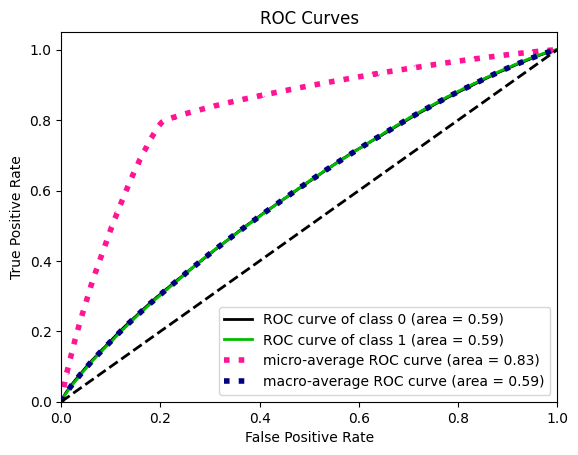

In [18]:
skplt.metrics.plot_roc_curve(y_test_clf, xgbc.predict_proba(x_test))
plt.show()

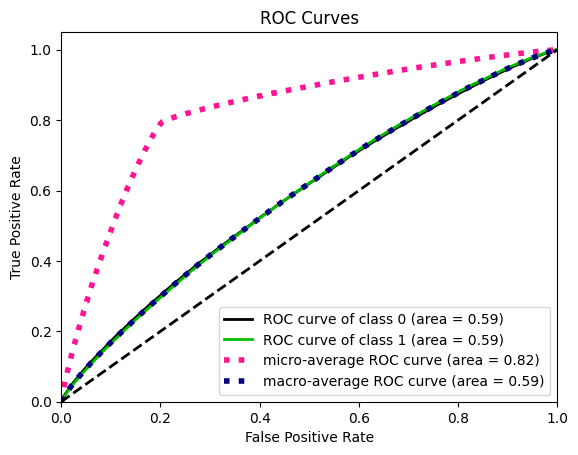

In [19]:
skplt.metrics.plot_roc_curve(y_test_clf, cbc.predict_proba(x_test))
plt.show()

In [20]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(eval_pool_clf)

In [21]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [22]:
shap.force_plot(explainer.expected_value, shap_values[0:100,:], x_train.iloc[0:100,:])

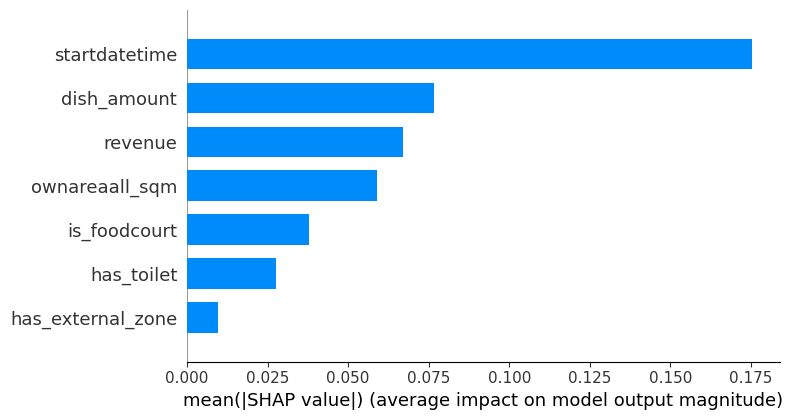

In [23]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

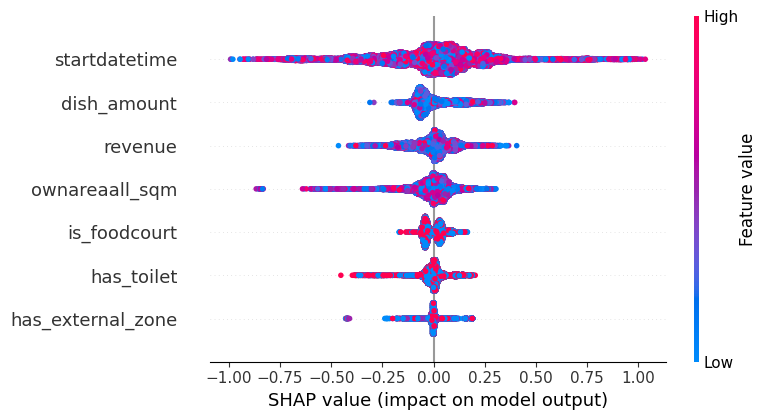

In [24]:
shap.summary_plot(shap_values[:100000], x_train[:100000])

# Train model on the full data

In [25]:
#cbc.load_model('/kaggle/working/cbc')
#cbr.load_model('/kaggle/working/cbc')
#xgbc.load_model('/kaggle/working/xgbc.json')

In [26]:
cbc = CatBoostClassifier(iterations=200, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(full_train_clf, eval_set=eval_pool_clf)

0:	learn: 0.5675230	test: 0.5673385	best: 0.5673385 (0)	total: 829ms	remaining: 2m 44s
1:	learn: 0.5245285	test: 0.5241764	best: 0.5241764 (1)	total: 2.02s	remaining: 3m 19s
2:	learn: 0.5099712	test: 0.5095068	best: 0.5095068 (2)	total: 3.23s	remaining: 3m 32s
3:	learn: 0.5047678	test: 0.5042483	best: 0.5042483 (3)	total: 4.43s	remaining: 3m 37s
4:	learn: 0.5028673	test: 0.5023032	best: 0.5023032 (4)	total: 5.68s	remaining: 3m 41s
5:	learn: 0.5019468	test: 0.5013511	best: 0.5013511 (5)	total: 6.76s	remaining: 3m 38s
6:	learn: 0.5015974	test: 0.5009922	best: 0.5009922 (6)	total: 7.86s	remaining: 3m 36s
7:	learn: 0.5013757	test: 0.5007503	best: 0.5007503 (7)	total: 8.93s	remaining: 3m 34s
8:	learn: 0.5012416	test: 0.5006168	best: 0.5006168 (8)	total: 10s	remaining: 3m 32s
9:	learn: 0.5011225	test: 0.5004976	best: 0.5004976 (9)	total: 11.2s	remaining: 3m 33s
10:	learn: 0.5010250	test: 0.5004008	best: 0.5004008 (10)	total: 12.2s	remaining: 3m 29s
11:	learn: 0.5009098	test: 0.5002927	best: 

In [27]:
cbr = CatBoostRegressor(iterations=200, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(full_train_reg, eval_set=eval_pool_reg)

0:	learn: 16.0716368	test: 16.0660597	best: 16.0660597 (0)	total: 870ms	remaining: 2m 53s
1:	learn: 16.0646525	test: 16.0591664	best: 16.0591664 (1)	total: 1.79s	remaining: 2m 57s
2:	learn: 16.0604069	test: 16.0551034	best: 16.0551034 (2)	total: 2.65s	remaining: 2m 53s
3:	learn: 16.0586849	test: 16.0532514	best: 16.0532514 (3)	total: 3.42s	remaining: 2m 47s
4:	learn: 16.0573156	test: 16.0518132	best: 16.0518132 (4)	total: 4.31s	remaining: 2m 47s
5:	learn: 16.0559703	test: 16.0503565	best: 16.0503565 (5)	total: 5.04s	remaining: 2m 42s
6:	learn: 16.0547073	test: 16.0490995	best: 16.0490995 (6)	total: 5.79s	remaining: 2m 39s
7:	learn: 16.0538302	test: 16.0479886	best: 16.0479886 (7)	total: 6.64s	remaining: 2m 39s
8:	learn: 16.0528526	test: 16.0470497	best: 16.0470497 (8)	total: 7.53s	remaining: 2m 39s
9:	learn: 16.0519474	test: 16.0460846	best: 16.0460846 (9)	total: 8.32s	remaining: 2m 38s
10:	learn: 16.0509791	test: 16.0450222	best: 16.0450222 (10)	total: 9.1s	remaining: 2m 36s
11:	learn

In [28]:
xgbc = XGBClassifier()
xgbc.fit(x, y_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
cbc.save_model('cbc')
cbr.save_model('cbr')
xgbc.save_model('xgbc.json')

# Predicting results

In [30]:
test_data = pd.read_parquet('/kaggle/input/burger-king-churn/hackaton2023_test.gzip')
test_data.sample(5)

,customer_id,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
686181,6504180,test,10.00,2023-06-18 23:32:19,Влажная салфетка,277.50,Отдельно стоящий с внешней зоной
663380,6355886,test,44.99,2022-10-07 18:00:27,Соус Сырный,119.20,Фудкорт без туалета
2316150,20147293,test,139.98,2022-11-04 15:26:21,Кинг Фри мал,140.00,Фудкорт без туалета
1612451,12419122,test,9.99,2023-07-20 19:08:47,Соус Сырный,160.30,Фудкорт с туалетом
3267625,25548628,test,183.99,2022-09-17 13:53:27,Биг Кинг Джуниор,306.84,Отдельно стоящий с внешней зоной


In [31]:
print(len(test_data.customer_id.unique()))
unique = test_data.customer_id.unique()
test_data = preprocess(test_data, is_train=False)
print(len(test_data['customer_id'].unique()))
test_data.head()

112334
112334


,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount
0,0,28039329,"[934, 788, 789]",1.662077e+09,False,0,True,1179.96,169.73,3
1,1,33602398,"[599, 81, 611, 282, 803, 860, 561, 860, 544, 8...",1.662078e+09,True,2,False,619.95,306.84,13
2,2,28039329,[934],1.662078e+09,False,0,True,289.99,169.73,1
3,3,29250460,"[846, 605, 666, 666, 605, 471, 183, 471, 289, ...",1.662079e+09,True,2,False,828.93,300.00,13
4,4,19197657,[916],1.662080e+09,True,1,False,69.99,338.30,1


In [32]:
out = pd.DataFrame()
out['customer_id'] = test_data['customer_id']
test_x = test_data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]

out['date_diff_post'] = cbr.predict(test_x)
out['buy_post'] = cbc.predict(test_x)

print(out.dtypes)
out.head()

customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,28039329,12.074194,0
1,33602398,16.645013,1
2,28039329,14.071445,0
3,29250460,13.895592,1
4,19197657,14.192027,1


In [33]:
#aggregate predictions for paychecks to formulate a prediction for a single user
out = out.groupby('customer_id', as_index=False).mean().round(0)
out['date_diff_post'] = out['date_diff_post'].astype(int)
out['buy_post'] = out['buy_post'].astype(int)

for n, val in enumerate(out['buy_post']):
    if val == 0:
        out['date_diff_post'][n] = None
        
print(len(out.customer_id.unique()))
print(out.dtypes)
out.head()

112334
customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,52341,17.0,1
1,69175,16.0,1
2,73427,15.0,1
3,134577,17.0,1
4,156357,17.0,1


In [34]:
out.to_csv('/kaggle/working/solution.csv', sep=';')